# 평가문항

1. 캐글 데이터분석 전과정이 성공적으로 진행되었는가?

- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 만든 csv파일을 캐글 My submission까지 진행했고, submission 결과를 이미지로 제출하였다.

2. 전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?

- 제출한 주피터노트북 파일이 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.

3. 회귀모델 예측정확도가 기준 이상 높게 나왔는가?

- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기

In [6]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import scipy as sp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
from xgboost import XGBRegressor
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import missingno as msno
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

from scipy import stats
%matplotlib inline

print(xgboost.__version__)
print(lightgbm.__version__)
print(msno.__version__)
print(sklearn.__version__)

1.7.4
3.3.5
0.5.2
1.0.2


## 1. 데이터 탐색

### 1.1 문제 정의

집의 다양한 정보를 가지고 가격을 예측하는 회귀분석 문제

평가: RMSE 

분석 전 고찰해보기

- 시애틀 근처에 금싸라기 땅을 찾자! - zipcode, lat, long, 등등
- 집값 폭등 시기와 같이 시계열적 영향이 있을까? <-- 1년으로 비교적 짧은 기간이라 확인하기 어려움, year, month, date(int)로 적용
- 집 특성별 price에 영향을 미치는 요소를 확인해보자

In [7]:
data_dir = '.'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
y = train['price']

# del train['price'] # 시각화 편의상 삭제 X

train_len = len(train)
t_data = pd.concat([train.drop('price', axis=1), test], axis= 0).reset_index(drop=True)

In [8]:
train.shape, test.shape

((15035, 21), (6468, 20))

In [9]:
t_data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [10]:
col = list(t_data.columns)

#### 데이터 설명

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

### 1.2 데이터 살펴보기

- 각 데이터 컬럼별 범위, 분포, 이상치 확인
- price 컬럼과의 상관관계 확인
- 새로운 변수 생성 아이디어 획득

### 1) 결측치 확인

<AxesSubplot:>

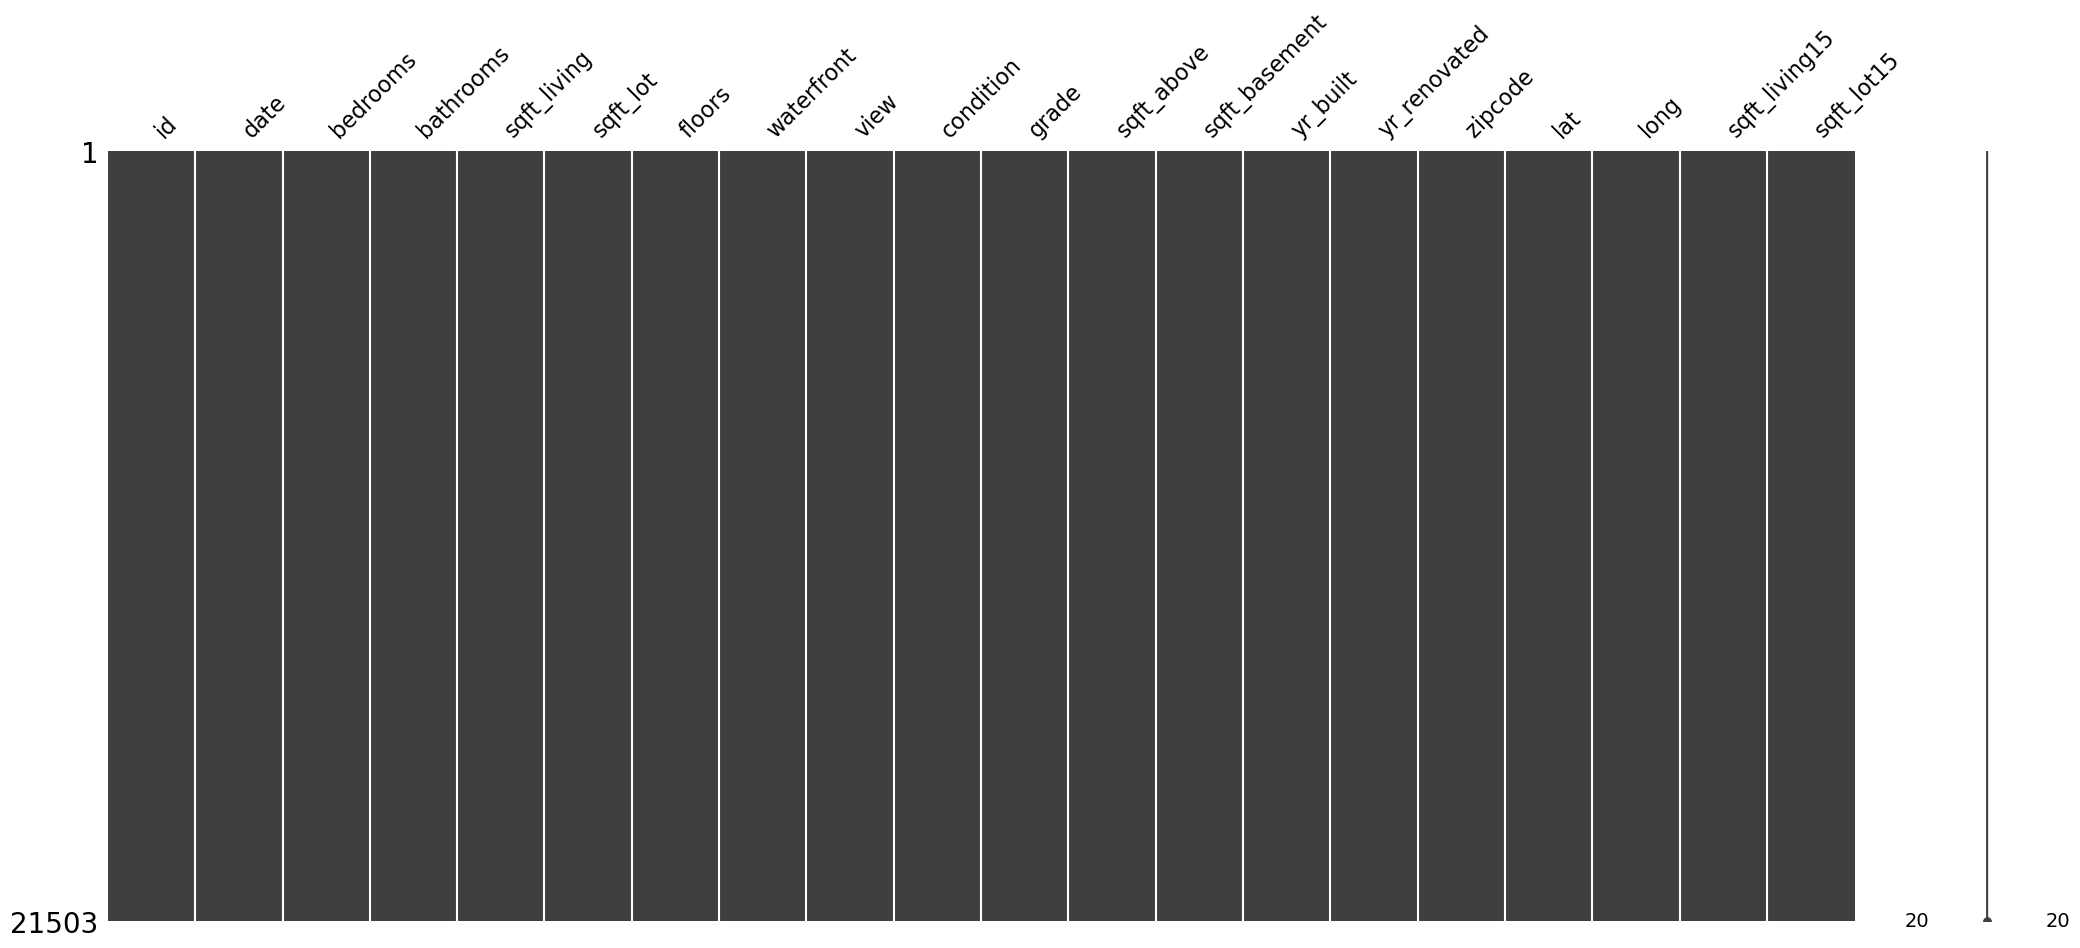

In [11]:
msno.matrix(t_data)

### 2) 변수별 범위 및 분포 확인

#### (1) 목적변수

In [12]:
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

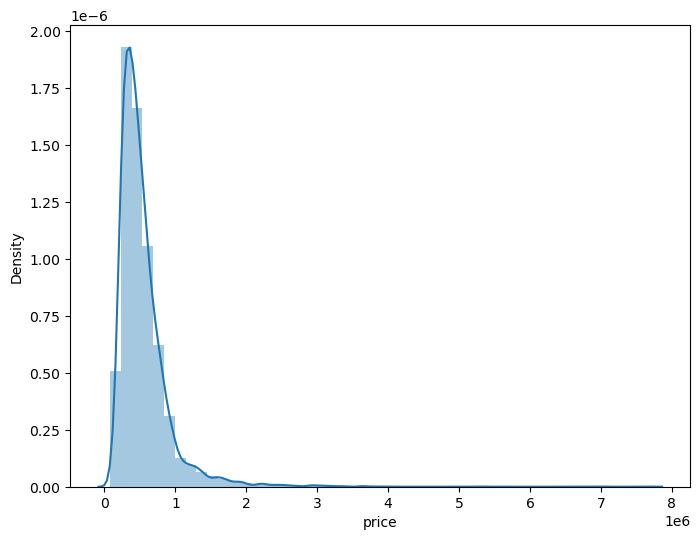

In [13]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y)

In [14]:
#skewness and kurtosis
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

Skewness: 4.290252
Kurtosis: 40.154919


=> price가 정규분포를 따르지 않고 분산이 큰 양상을 보임

작업 진행 - log_price: normalization

#### - log_price

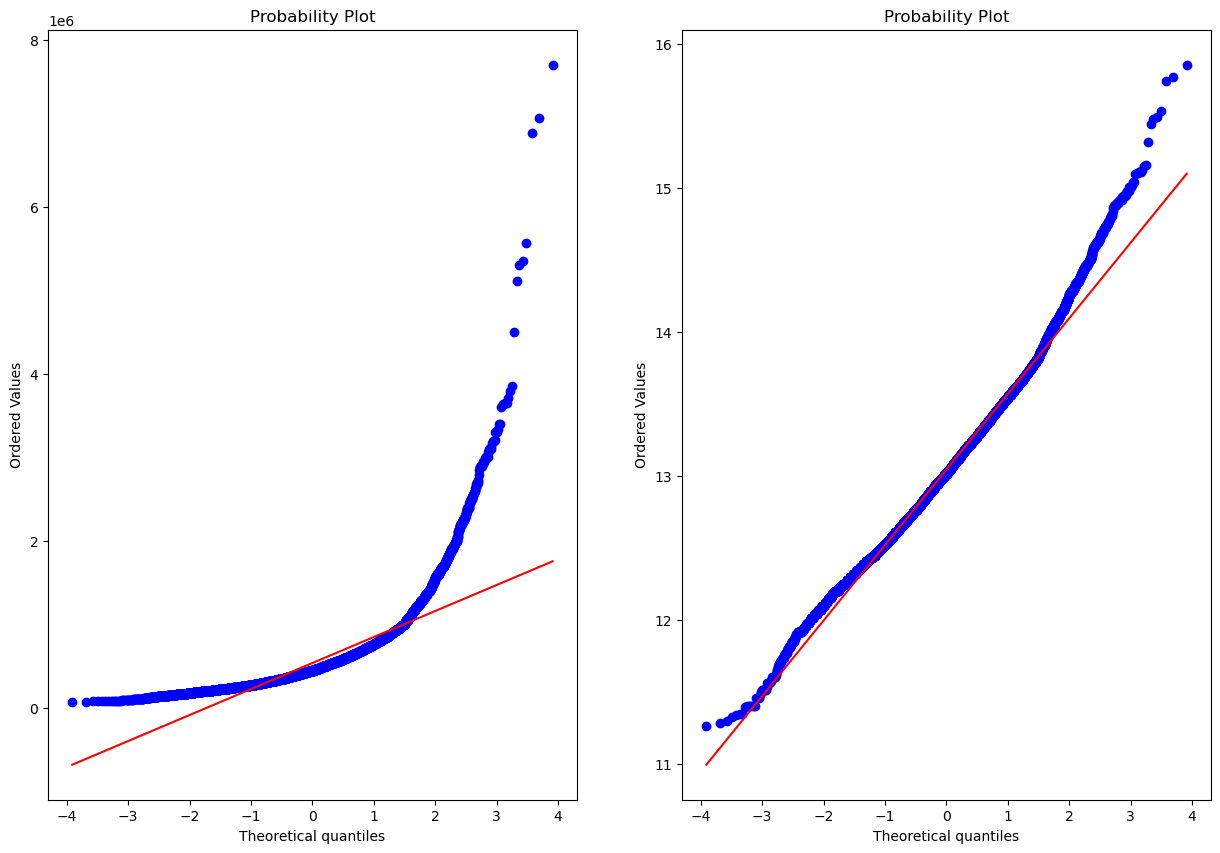

In [15]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(y, plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(y), plot=plt)

<AxesSubplot:xlabel='price', ylabel='Density'>

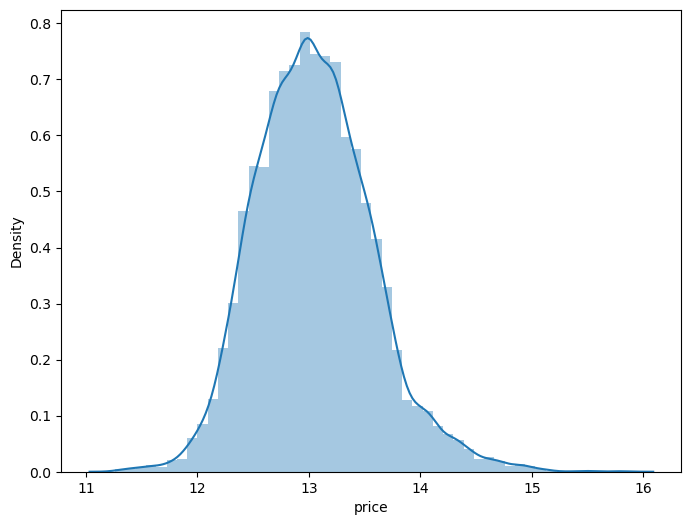

In [16]:
log_y = np.log1p(y)
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(log_y)

=> 정규분포에 가깝게 변환된 것을 볼 수 있다.

#### - price_per_living

등급, 지역, 시간 등의 영향을 보기 위해 일단 주거공간 면적을 기준으로 집의 평당 가격 계산 - 데이터 EDA에 사용

-> 나중에 집의 전체적 규모를 대표할 수 있는 변수 가공 필요

In [17]:
# 주거공간 기준 평당 price

y_per_living = y/train['sqft_living']

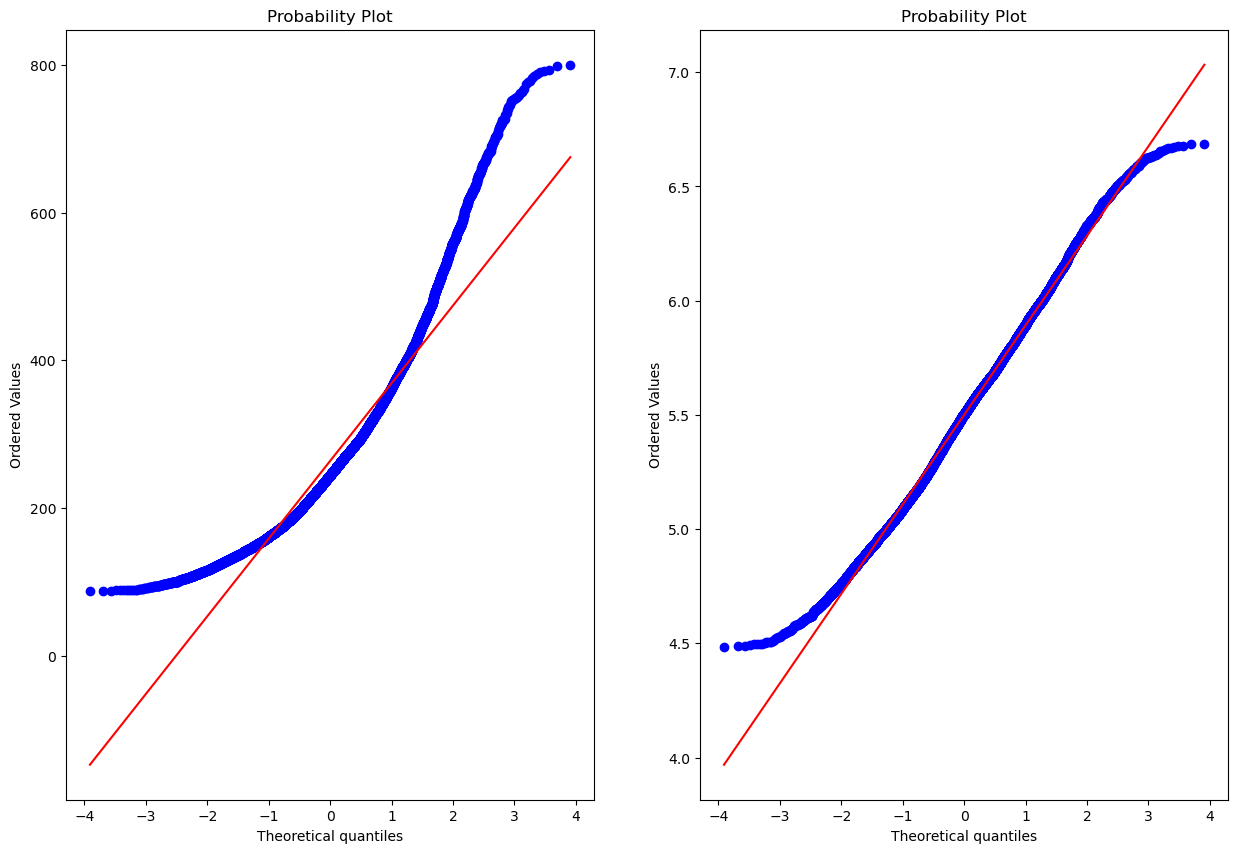

In [18]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(y_per_living, plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(y_per_living), plot=plt)

<AxesSubplot:ylabel='Density'>

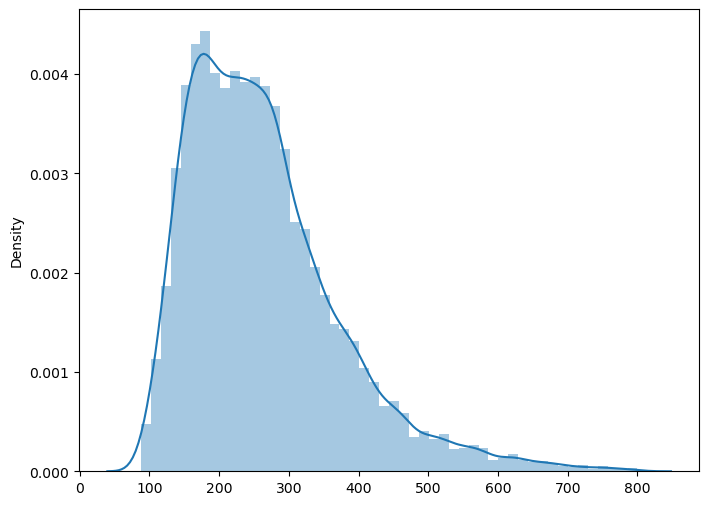

In [19]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(y_per_living)

#### 상관관계 분석

상관계수 상위 15개 변수 확인

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot']


<AxesSubplot:>

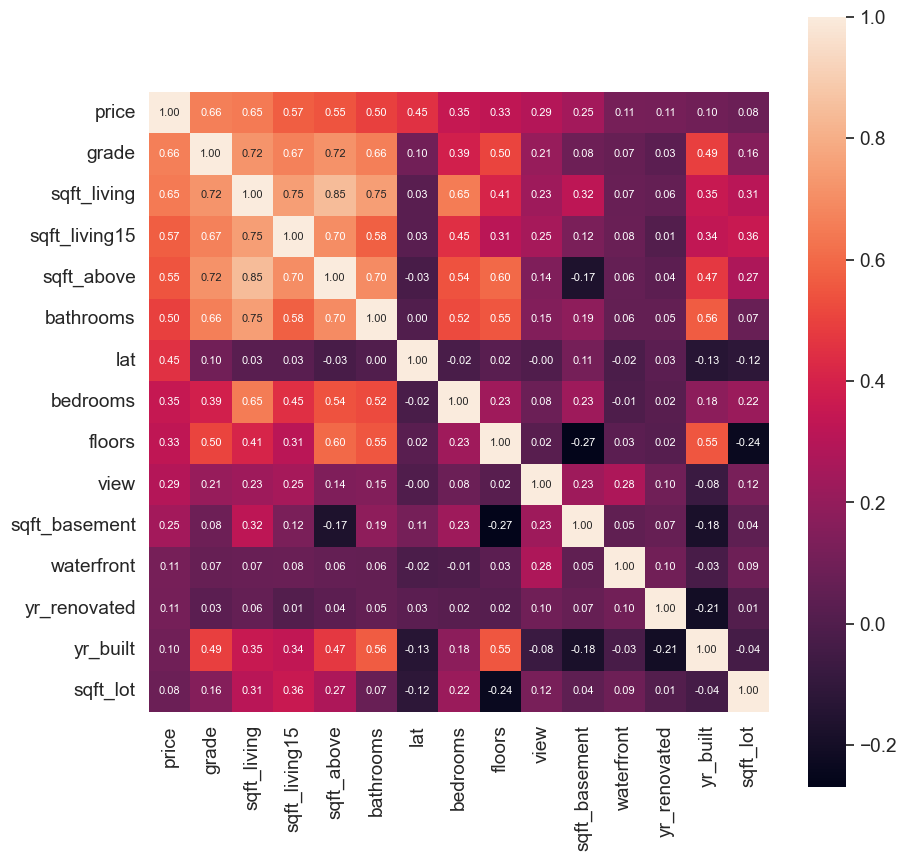

In [20]:
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=15, columns='price').index

cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size':8},
           xticklabels=cor_cols.values, yticklabels=cor_cols.values)

=> 목적변수와 상관도가 높은 변수는 grade, sqft_living, sqft_above 순으로 나타남

#### price - grade 관계

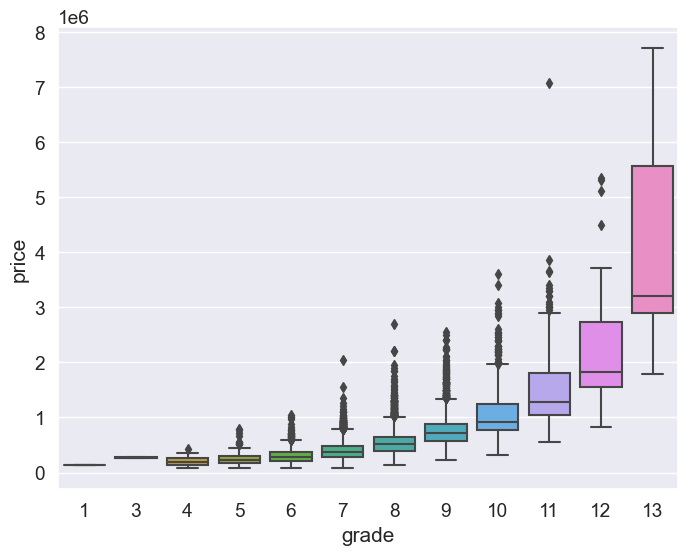

In [21]:
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

#### price - sqft_living(주거공간 면적)

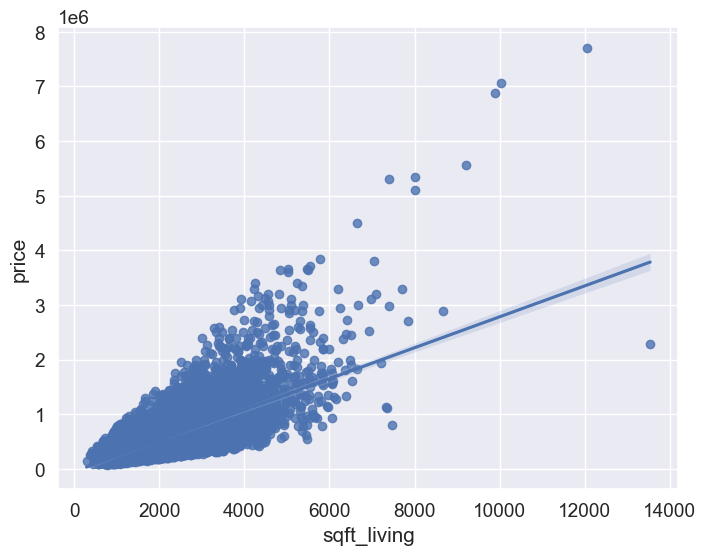

In [22]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

#### price - sqft_living15(15년 기준 주거공간 면적)

sqft_living에 비해 분산이 큼, sqft_living을 주로 사용하거나 변수 생성 등의 작업 필요성 있음

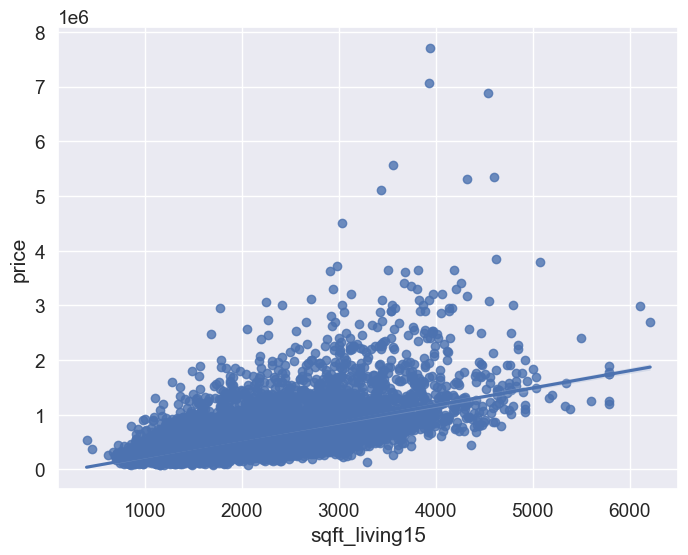

In [23]:
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

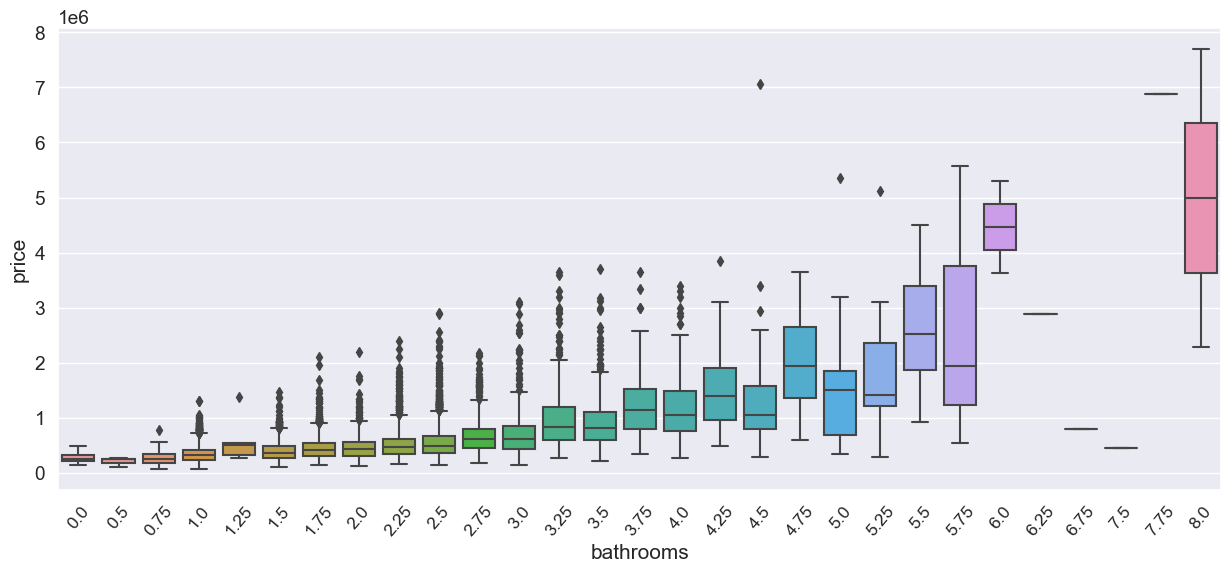

In [24]:
data = pd.concat([train.price, train.bathrooms], axis = 1)
f, ax = plt.subplots(figsize = (15,6))
ax.set_xticklabels(train['bathrooms'].unique(), rotation=50, fontsize='small')
fig = sns.boxplot(x = 'bathrooms', y = 'price', data = data) 

#### (1) 공간적 특성 변수 가공(lat, long, zipcode) + waterfront?

lat 컬럼의 경우 price와 상관성이 있으나 다른 컬럼에 비해 추세가 두드러지지 않음

zipcode와 함께 변수 전처리 진행

#### - lat, long

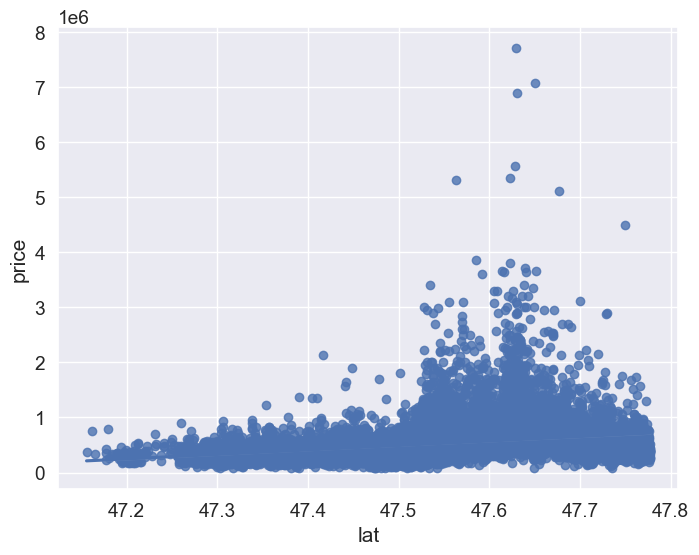

In [25]:
data = pd.concat([train['price'], train['lat']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='lat', y="price", data=data)

In [ ]:
import folium
from folium.plugins import MarkerCluster

# 지도 상에서 건물들의 위치 분포를 확인하기
# TRAIN

latitude = train.lat.mean()
longitude = train.long.mean()
m = folium.Map(
    location=[latitude, longitude],
    zoom_start=9
)

coords = train[['lat', 'long']]

marker_cluster = MarkerCluster().add_to(m)

for lat, long in zip(coords['lat'], coords['long']):
    folium.Marker([lat, long], icon = folium.Icon(color="green")).add_to(marker_cluster)
    
# m # 가시화

In [ ]:
# TEST

latitude = test.lat.mean()
longitude = test.long.mean()
m = folium.Map(
    location=[latitude, longitude],
    zoom_start=9
)

coords = test[['lat', 'long']]

marker_cluster = MarkerCluster().add_to(m)

for lat, long in zip(coords['lat'], coords['long']):
    folium.Marker([lat, long], icon = folium.Icon(color="green")).add_to(marker_cluster)
    
# m # 가시화

#### - zip code 시각화

zip code 숫자 증가에 따른 추세는 없지만 최소값, 평균값 차이는 있는 것으로 생각됨

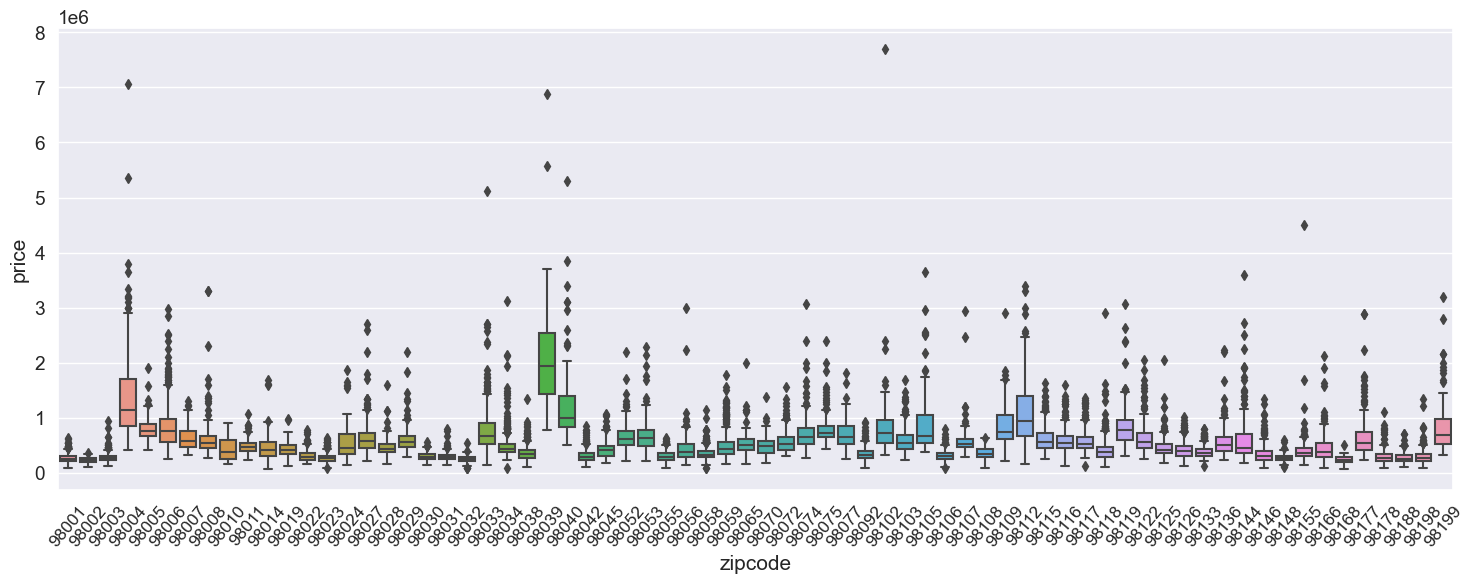

In [27]:
data = pd.concat([y, train['zipcode']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
ax.set_xticklabels(train['zipcode'].unique(), rotation=50, fontsize='small')
fig = sns.boxplot(x='zipcode', y=y, data=train)

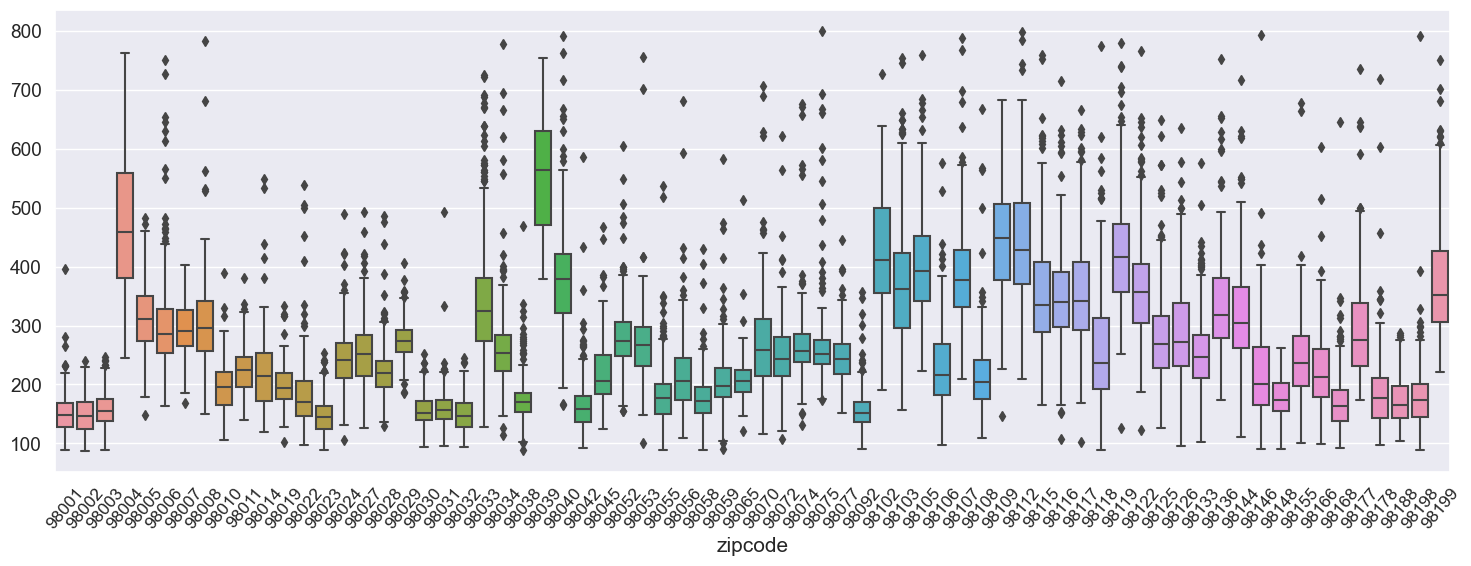

In [28]:
data = pd.concat([y_per_living, t_data['zipcode']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
ax.set_xticklabels(t_data['zipcode'].unique(), rotation=50, fontsize='small')
fig = sns.boxplot(x='zipcode', y=y_per_living, data=data)

#### 2) 시간적 특성

date 값은 일까지 표기됨

-> datetime 객체로 변환, day, month, year 분리

In [29]:
len(set(t_data['date']))

372

2014.05~ 2015.05 : 약 1년 가량의 범위를 가지고 있음

-> sqft_living/lot 15 - 재건축 변화가 있을 경우 후의 변화에 해당됨

--> 구매 일자가 14년도일 경우 변화가 없어야함

In [30]:
t_data['date'] = t_data['date'].str[:8]
train['date'] = train['date'].str[:8]

In [31]:
t_data['year'] = t_data['date'].str[:4].astype('int')
t_data['month'] = t_data['date'].str[4:6].astype('int')
t_data['day'] = t_data['date'].str[6:8].astype('int')

train['year'] = train['date'].str[:4].astype('int')
train['month'] = train['date'].str[4:6].astype('int')
train['day'] = train['date'].str[6:8].astype('int')

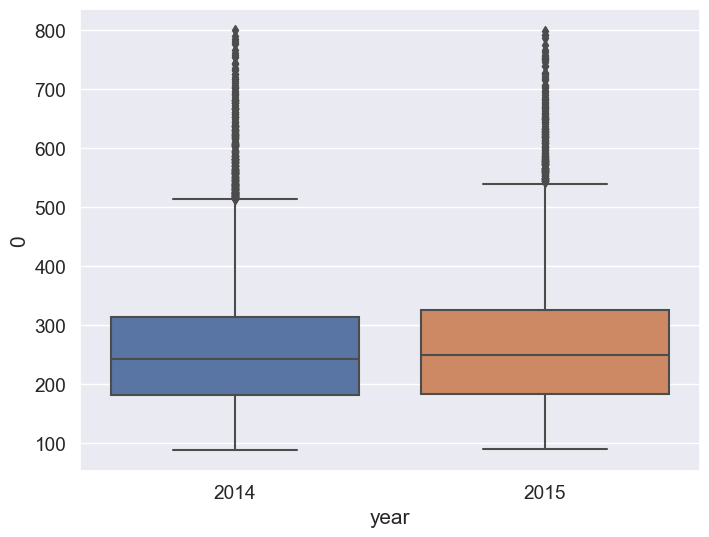

In [32]:
data = pd.concat([y_per_living, train['year']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='year', y=0, data=data)

3) 건물 객체 특성

yr_built : 지어진 년도

yr_renovated : 집을 재건축한 년도

bedrooms

bathrooms

'sqft_living',
'sqft_living15'- 서로 차이에 따른 변화 면적 구하기 -> gap_living

'sqft_lot15'
'sqft_lot' - 서로 차이에 따른 변화 면적 구하기 -> gap_lot

grade

view

waterfront

floors 

condition

sqft_above : 지하실을 제외한 평방 피트(면적)
sqft_basement : 지하실의 평방 피트(면적)

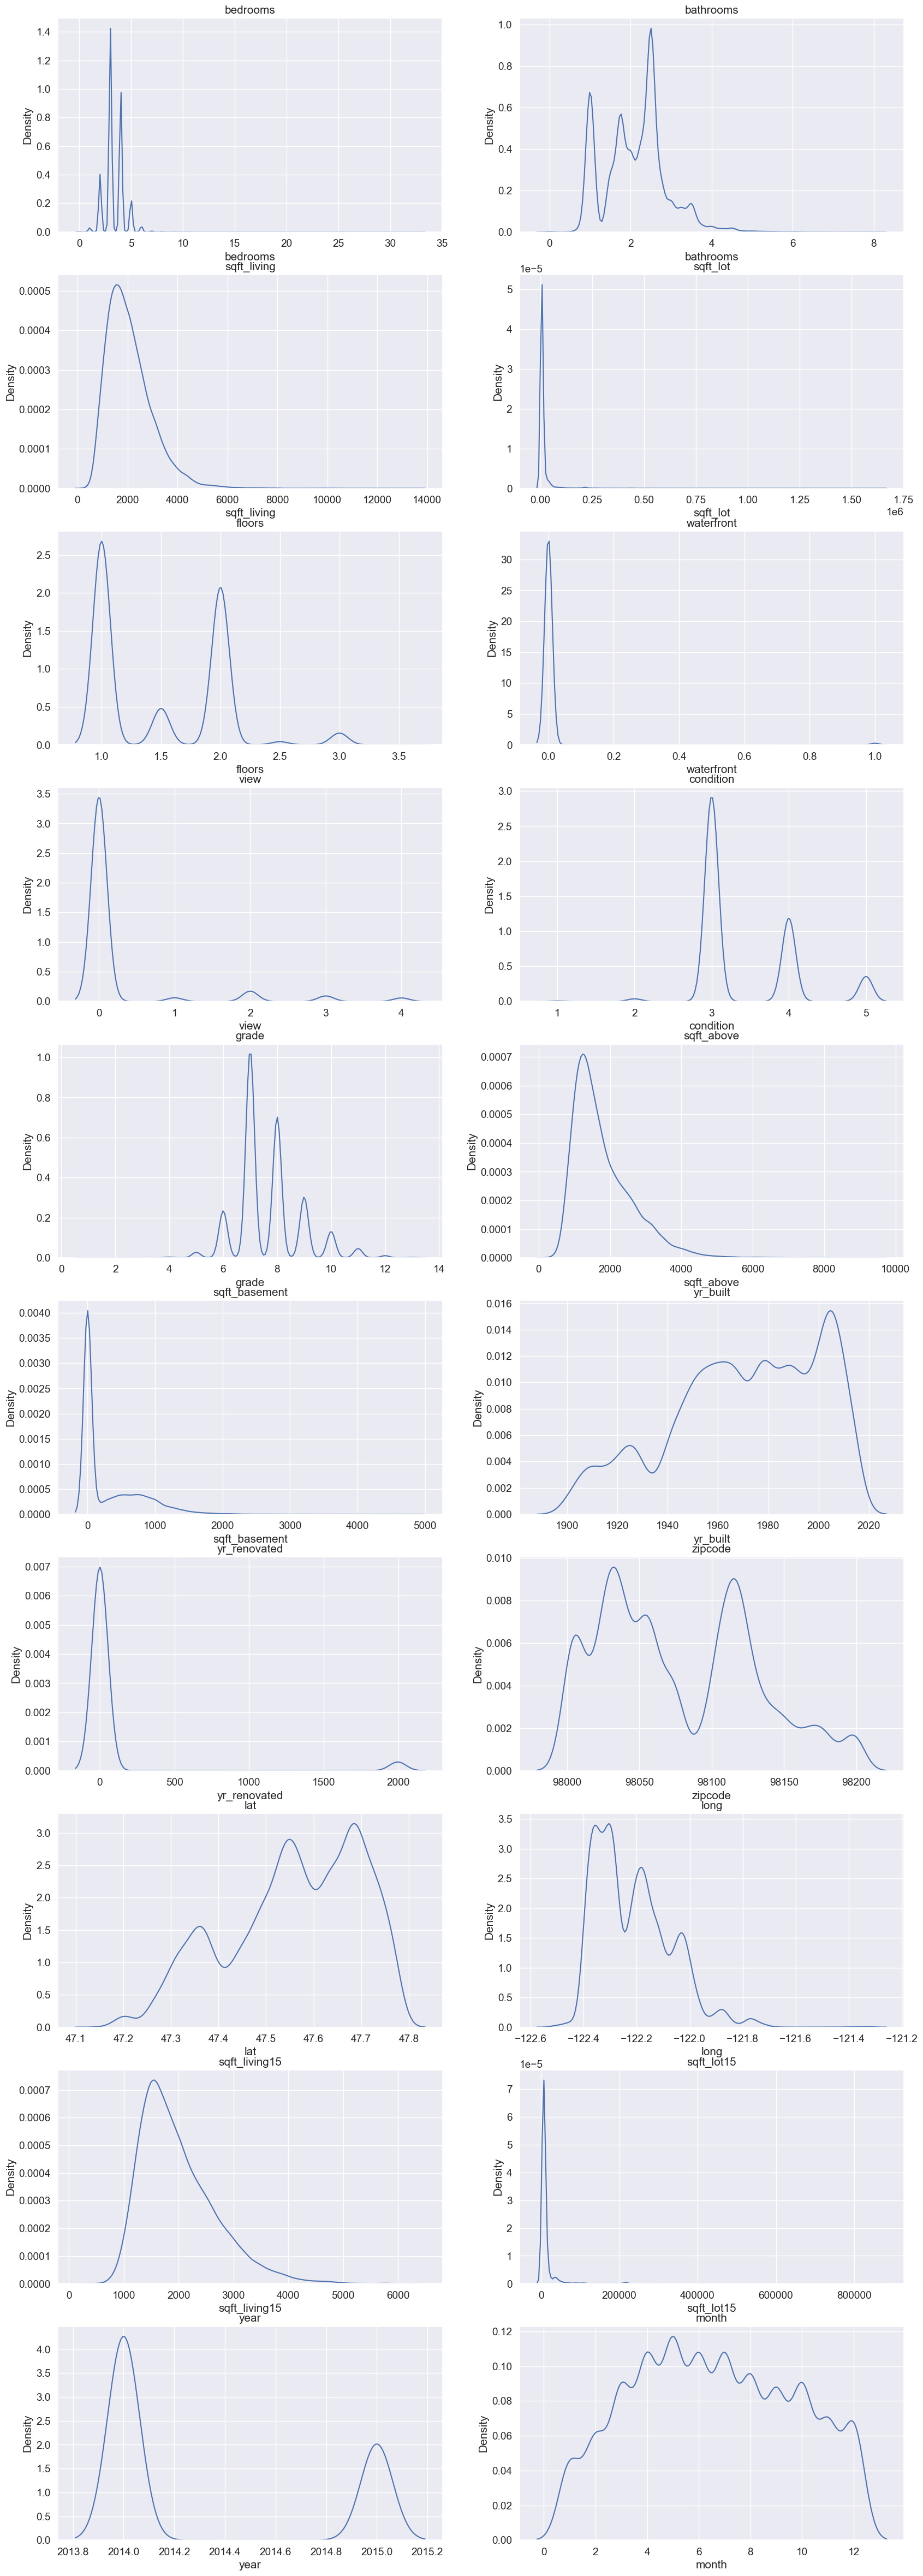

In [33]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id, price 변수는 제외하고 분포를 확인합니다.
count = 0
columns = t_data.columns[2:]
for row in range(10):
    for col in range(2):
        sns.kdeplot(t_data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == len(columns) :
            break

## 2. Feature engineering

### 2.1 log_scaling

In [34]:
def log_scaling(df, skew_columns):
    for c in skew_columns:
        df[c] = np.log1p(df[c].values)
    return df

### 2.2 lat, long, zipcode

lat, long -> (lat - long)

zipcode 단위별 분류

lat, long, zipcode

In [35]:
def lat_long(df):
    df['gap_lat_long'] = df['lat'] - df['long']
    
    return df

In [36]:
def sep_zipcode(df):
    df['zipcode_str'] = df['zipcode'].astype(str)  
    df['zipcode-3'] = df['zipcode_str'].str[2:3]
    df['zipcode-4'] = df['zipcode_str'].str[3:4]
    df['zipcode-5'] = df['zipcode_str'].str[4:5]
    df['zipcode-34'] = df['zipcode_str'].str[2:4]
    df['zipcode-45'] = df['zipcode_str'].str[3:5]
    df['zipcode-35'] = df['zipcode_str'].str[2:3] + df['zipcode_str'].str[4:5]
    df.drop(['zipcode_str'], 1, inplace=True)
    
    return df

lat, long, zipcode, waterfront로 건물 클러스터링하고 평당가격 확인해보기

In [37]:
kmeans = KMeans(n_clusters=8, random_state=0, n_init=1).fit(train[['lat','long','zipcode','waterfront']].values)
train['zipclass'] = kmeans.labels_

In [38]:
kmeans.cluster_centers_

array([[ 4.75110430e+01, -1.22148733e+02,  9.80304587e+04,
         5.29430084e-03],
       [ 4.76410682e+01, -1.22333805e+02,  9.81429792e+04,
         1.00000000e-02],
       [ 4.76199449e+01, -1.22049749e+02,  9.80723727e+04,
         2.37691002e-02],
       [ 4.76312822e+01, -1.22329405e+02,  9.81187732e+04,
         2.47831475e-03],
       [ 4.75295810e+01, -1.22327807e+02,  9.81822539e+04,
         2.04081633e-02],
       [ 4.75197953e+01, -1.22103388e+02,  9.80525799e+04,
         1.71453065e-03],
       [ 4.75149205e+01, -1.22173134e+02,  9.80056584e+04,
         6.07064018e-03],
       [ 4.75807089e+01, -1.22314163e+02,  9.81032431e+04,
         1.92926045e-03]])

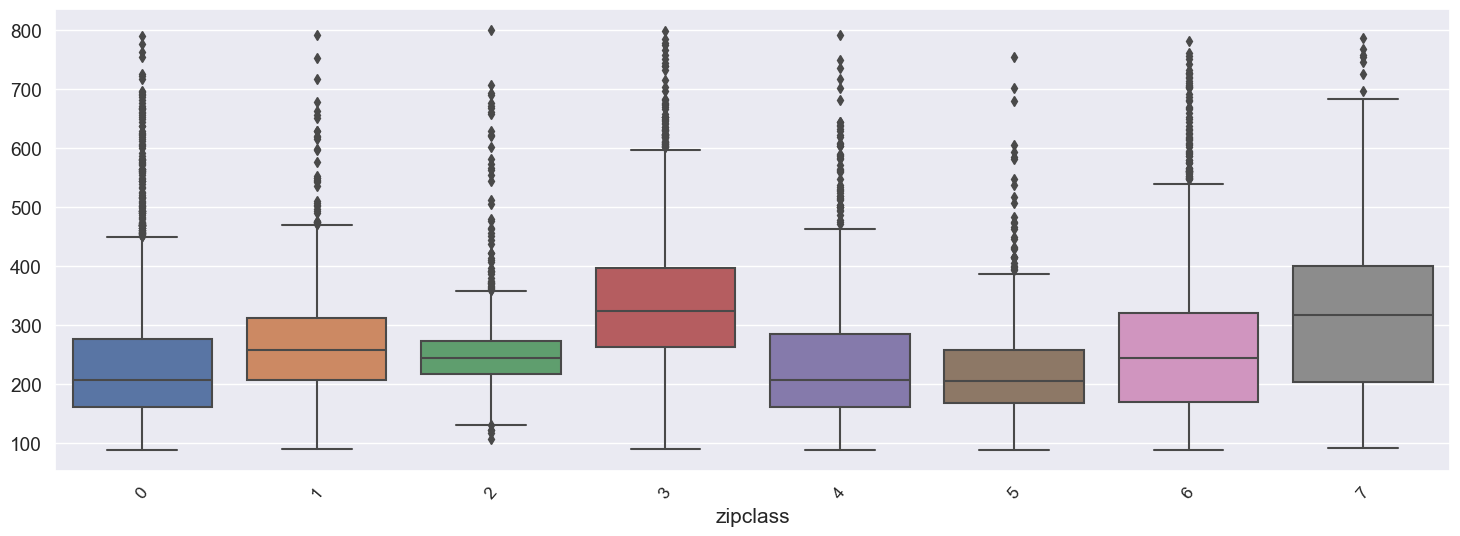

In [39]:
data = pd.concat([y_per_living, train['zipclass']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
ax.set_xticklabels(train['zipclass'].unique(), rotation=50, fontsize='small')
fig = sns.boxplot(x=train['zipclass'], y=y_per_living, data=data)

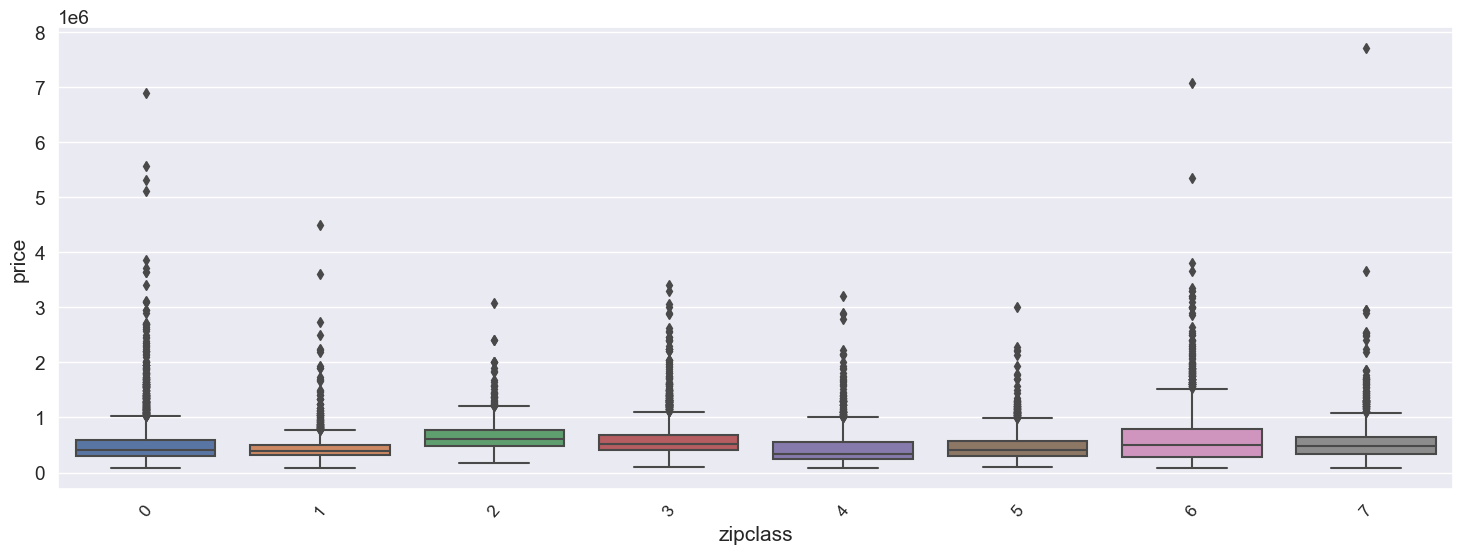

In [40]:
data = pd.concat([y, train['zipclass']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
ax.set_xticklabels(train['zipclass'].unique(), rotation=50, fontsize='small')
fig = sns.boxplot(x=train['zipclass'], y=y, data=data)

- 타겟, 독립변수간 상관관계 확인

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view' 'sqft_basement' 'waterfront'
 'yr_renovated' 'yr_built' 'sqft_lot']


<AxesSubplot:>

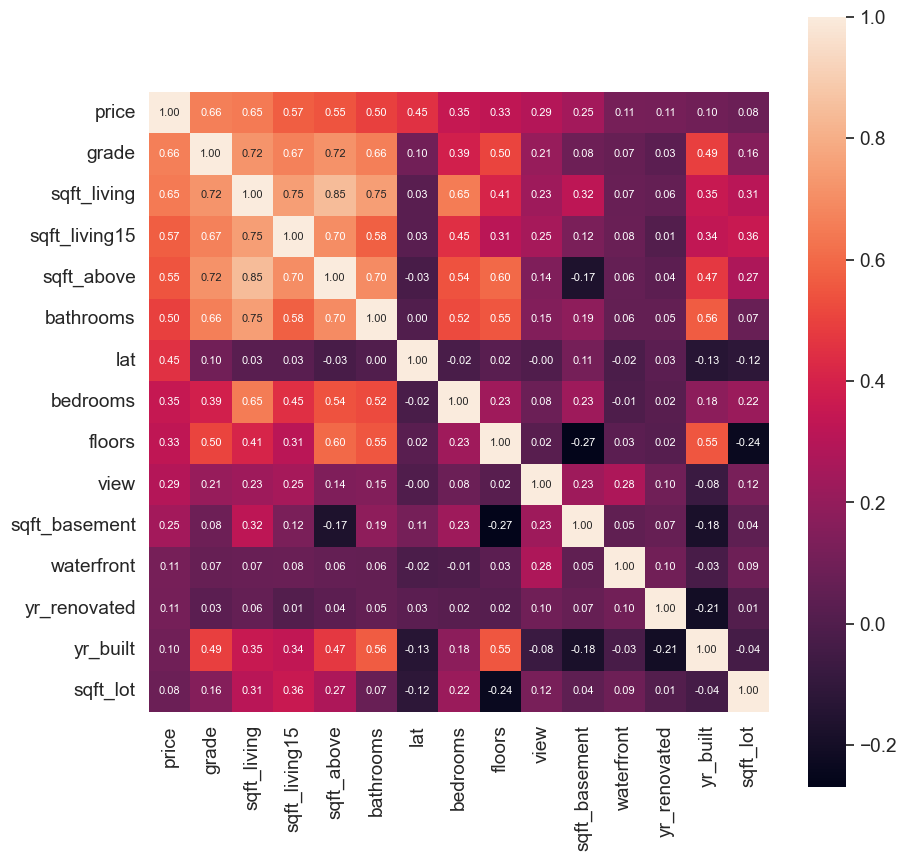

In [41]:
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=15, columns='price').index

cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True, annot_kws={'size':8},
           xticklabels=cor_cols.values, yticklabels=cor_cols.values)

In [2]:
# 클러스터링 값은 price랑 상관관계가 적어 일단 보류
def cluster_latlongzip(X):
    kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
    kmeans.labels_
    kmeans.predict([[0, 0], [12, 3]])
    kmeans.cluster_centers_

### 2.3 yr_renobated

0인 행이 많이 포함되어 있음 -> 지어진 해를 0인 행에 업데이트해 최신 증축연도를 나타내는 열으로 업데이트

In [43]:
t_data.yr_renovated.unique()

array([   0, 2002, 1999, 1991, 1978, 2005, 2008, 2003, 1994, 1984, 1954,
       2014, 2011, 1974, 1983, 2013, 1990, 1957, 1977, 1981, 1995, 2000,
       1986, 1992, 2004, 2007, 1987, 2006, 1985, 1971, 1945, 1979, 1997,
       2010, 1969, 1948, 2009, 1970, 2015, 1989, 2001, 1968, 2012, 1963,
       1993, 1962, 1972, 1980, 1998, 1955, 1996, 1950, 1956, 1982, 1988,
       1940, 1946, 1975, 1964, 1958, 1976, 1973, 1967, 1965, 1944, 1951,
       1953, 1959, 1960, 1934], dtype=int64)

In [44]:
len(t_data) ,len(t_data[t_data['yr_renovated'] == 0])

(21503, 20590)

In [3]:
# 증축 여부
def set_yr_renovated(df):
    
    # renovated year update
    df.loc[df.yr_renovated==0,'yr_renovated']=df[df.yr_renovated==0].yr_built
    
    # 증축 여부
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    
    return df

### 2.4 sqft_living, sqrt_lot

15년 기준 주거/부지 면적에서 이전 주거/부지 면적의 차이를 나타냄

구매일을 기준으로 15년도 전이면 구매 가격에 영향을 미치지 않을 것이라 생각하고 0값을 부여함

-값이 포함되어 있다 -> 증축만 있지 않고 다양한 리모델링을 진행한 것으로 추정

In [47]:
def set_sqft_gap(df):
    df['living_gap'] = df.sqft_living15 - df.sqft_living
    df['lot_gap'] = df.sqft_lot15 - df.sqft_lot
    #df.loc[df['year'] == 2014, 'living_gap'] = 0
    #df.loc[df['year'] == 2014, 'lot_gap'] = 0
    return df

In [4]:
# 건물 규모 - 총 침실, 화장실 수, 등급 및 컨디션, 전체 부지 중 주거공간 비율 등 변수 생성
def set_total_rooms(df):
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['grade_condition'] = df['grade'] * df['condition']
    
    # 주거공간의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15'] 
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    return df

### 2.5 추가 예정

##### 아이디어

- waterfront, lat, long, zipcode로 클러스터링해서 노른자 땅을 찾아보자 <- lat, long, zipcode 와 평당 가격간 상관관계의 경우 확인하기 어려움
- 집을 구매한 날짜의 추세를 보고 시계열성이 있는지 <- 1년간 데이터에서 일정한 부동산 가격 상승을 확인하기 어려움
- 같은 등급의 집들을 클러스터링하고 지역, 시간적 변수에 따른 영향력 비교 

##### 추가 정보

zipcode : 벨뷰 안에서도 가장 비싼 지역이라고 알려진 우편번호 98004 지역(클라이드힐, 메이덴바우어, 에나타이 등)은 2021년도 거래 기준 신축 단독주택은 500만불 이상고, 워싱턴레이크 조망권은 1천만불에서 2천만불대에 매물이 형성되고 있다. 일단 우편번호가 98004이고, 경사지대가 아니기만 하면 거주가 불가능할 정도로 낙후된 집이라도 땅값으로만 200만불 정도에 거래된다.

## 3. 모델링

### 3.1 Average Blending

In [49]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

### 3.2 하이퍼 파라미터 최적화

In [87]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    grid_model = GridSearchCV(model['model'], param_grid = param_grid, \
                        scoring = 'neg_mean_squared_error', \
                        #early_stopping_rounds = 20,
                        cv=5, verbose = verbose, n_jobs = n_jobs) 

    grid_model.fit(train, y) 

    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results, grid_model.best_estimator_

### 3.3 Cross Validation

In [51]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle=True, random_state=2020).get_n_splits(X.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], X.values, y)), 
                                             kf=kfold))

In [52]:
def rmse_exp(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [53]:
def get_scores(models, train, y, exp_true = True):
    # 답안 작성
    df = {}

    for m in models:
        # 모델 이름 획득
        model_name = m['model'].__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        m['model'].fit(X_train, y_train)
        
        # 예측
        y_pred = m['model'].predict(X_test)
        
        # 예측 결과의 rmse값 저장
        if exp_true == True:
            df[model_name] = rmse_exp(y_test, y_pred)
        else:
            df[model_name] = rmse(y_test, y_pred)
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

## 4. Make Submission

In [54]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 4.1 기본 데이터셋 [t_data, y]

- log scaling 없음
- 주어진 기본 데이터셋에 date만 year, month 변환

In [55]:
data_columns = [ 'bedrooms',
                 'bathrooms',
                 'sqft_living',
                 'sqft_lot',
                 'floors',
                 'waterfront',
                 'view',
                 'condition',
                 'grade',
                 'sqft_above',
                 'sqft_basement',
                 'yr_built',
                 'yr_renovated',
                 'zipcode',
                 'lat',
                 'long',
                 'sqft_living15',
                 'sqft_lot15',
                 'month',
                 'year']
target_column = 'price' #log_price

In [56]:
X = t_data.iloc[:train_len, :][data_columns]
sub = t_data.iloc[train_len:, :][data_columns]

In [57]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,10,2014
1,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2,2015
2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2,2015
3,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,6,2014
4,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,1,2015


In [58]:
random_state=2020

gboost1 = GradientBoostingRegressor(random_state=random_state)
xgboost1 = XGBRegressor(random_state=random_state)
lightgbm1 = LGBMRegressor(random_state=random_state)
rdforest1 = RandomForestRegressor(random_state=random_state)

models1 = [{'model':gboost1, 'name':'GradientBoosting'}, {'model':xgboost1, 'name':'XGBoost'},
          {'model':lightgbm1, 'name':'LightGBM'}, {'model':rdforest1, 'name':'RandomForest'}]

In [59]:
get_scores(models1, X, y, exp_true = False)

,RMSE
GradientBoostingRegressor,130120.022629
RandomForestRegressor,126497.284290
LGBMRegressor,120218.516156
XGBRegressor,119701.673808


In [60]:
get_cv_score(models1)

Model GradientBoosting CV score : 0.8611
Model XGBoost CV score : 0.8815
Model LightGBM CV score : 0.8808
Model RandomForest CV score : 0.8661


In [61]:
y_pred = AveragingBlending(models1, X, y, sub)

In [62]:
sub_out = pd.DataFrame(data={'id':sub.index,'price':y_pred})

In [63]:
sub_out.to_csv('submission1.csv', index=False)

![nn](./assets/submission1.png)

#### 4.2 feature 추가 데이터셋

t_data에 목적변수 log_y 사용

feature llat_long 변수 추가, yr_renovated 업데이트, sqft living/lot gap 계산

In [64]:
feature_list = ['lat_long', 'sep_zipcode', 'log_scaling', 'set_yr_renovated', 'sqft_gap']

In [65]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 
                'sqft_above', 'sqft_basement','sqft_living15',
                'sqft_lot15']

t_data2 = t_data.copy(True)

t_data2 = lat_long(t_data2)

t_data2 = sep_zipcode(t_data2)

t_data2 = set_yr_renovated(t_data2)

t_data2 = set_sqft_gap(t_data2)

In [66]:
t_data2.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,gap_lat_long,zipcode-3,zipcode-4,zipcode-5,zipcode-34,zipcode-45,zipcode-35,is_renovated,living_gap,lot_gap
0,0,20141013,3,1.00,1180,5650,1.0,0,0,3,...,169.7682,1,7,8,17,78,18,0,160,0
1,1,20150225,2,1.00,770,10000,1.0,0,0,3,...,169.9709,0,2,8,02,28,08,0,1950,-1938
2,2,20150218,3,2.00,1680,8080,1.0,0,0,3,...,169.6618,0,7,4,07,74,04,0,120,-577
3,3,20140627,3,2.25,1715,6819,2.0,0,0,3,...,169.6367,0,0,3,00,03,03,0,523,0
4,4,20150115,3,1.50,1060,9711,1.0,0,0,3,...,169.7245,1,9,8,19,98,18,0,590,0


In [67]:
t_data2_columns = list(t_data2.columns)
t_data2_columns.remove('id')
t_data2_columns.remove('date')

In [68]:
# categorical label encoding
cat_cols = t_data2.select_dtypes('object').columns
for col in cat_cols:
    le = LabelEncoder()
    t_data2[col] = le.fit_transform(t_data2[col])

In [70]:
X = t_data2.iloc[:train_len, :][t_data2_columns]
sub = t_data2.iloc[train_len:, :][t_data2_columns]

In [71]:
random_state=2020

gboost2 = GradientBoostingRegressor(random_state=random_state)
xgboost2 = XGBRegressor(random_state=random_state)
lightgbm2 = LGBMRegressor(random_state=random_state)
rdforest2 = RandomForestRegressor(random_state=random_state)

models2 = [{'model':gboost2, 'name':'GradientBoosting'}, {'model':xgboost2, 'name':'XGBoost'},
          {'model':lightgbm2, 'name':'LightGBM'}, {'model':rdforest2, 'name':'RandomForest'}]

In [72]:
y_pred = AveragingBlending(models2, X, log_y, sub)

In [73]:
get_scores(models2, X, log_y, exp_true = True)

,RMSE
RandomForestRegressor,126180.652447
GradientBoostingRegressor,122270.260204
LGBMRegressor,112198.473236
XGBRegressor,109212.007158


RMSE 값이 줄어든 것을 볼 수 있다.

In [74]:
get_cv_score(models2)

Model GradientBoosting CV score : 0.8681
Model XGBoost CV score : 0.8905
Model LightGBM CV score : 0.8811
Model RandomForest CV score : 0.8674


In [75]:
y_pred = AveragingBlending(models2, X, log_y, sub)
y_pred = np.expm1(y_pred)
sub_out = pd.DataFrame(data={'id':sub.index,'price':y_pred})
sub_out.to_csv('submission2.csv', index=False)

![nn](./assets/sub_2.png)

In [76]:
from lightgbm import plot_importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

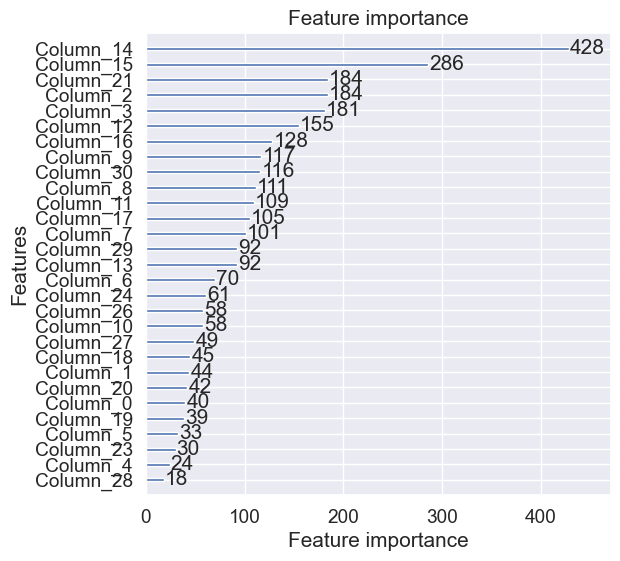

In [248]:
f, ax = plt.subplots(figsize=(6, 6))
plot_importance(lightgbm2, max_num_features=30, ax=ax)

#### 4.3 feature 추가

In [78]:
t_data3 = t_data.copy(True)

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 
                'sqft_above', 'sqft_basement','sqft_living15',
                'sqft_lot15']

t_data3 = log_scaling(t_data3, skew_columns)
t_data3 = lat_long(t_data3)
t_data3 = sep_zipcode(t_data3)
t_data3 = set_yr_renovated(t_data3)
t_data3 = set_total_rooms(t_data3)
t_data3 = set_sqft_gap(t_data3)

In [79]:
# df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400) # 날짜 줄 세우기

In [80]:
t_data3_columns = list(t_data3.columns)
t_data3_columns.remove('id')
t_data3_columns.remove('date')

In [81]:
# categorical label encoding
cat_cols = t_data3.select_dtypes('object').columns
for col in cat_cols:
    le = LabelEncoder()
    t_data3[col] = le.fit_transform(t_data3[col])

In [82]:
X = t_data3.iloc[:train_len, :][t_data3_columns]
sub = t_data3.iloc[train_len:, :][t_data3_columns]

In [83]:
random_state=2020

gboost3 = GradientBoostingRegressor(random_state=random_state)
xgboost3 = XGBRegressor(random_state=random_state)
lightgbm3 = LGBMRegressor(random_state=random_state)
rdforest3 = RandomForestRegressor(random_state=random_state)

In [118]:
models3 = [{'model':gboost3, 'name':'GradientBoosting'}, {'model':xgboost3, 'name':'XGBoost'},
          {'model':lightgbm3, 'name':'LightGBM'}, {'model':rdforest3, 'name':'RandomForest'}]

In [88]:
gboost3_grid = {
    'max_depth': [5,7,8,10], 
    'n_estimators': [1000,1500,2000]
}

res, gboost3 = my_GridSearch(models3[0], X, log_y, gboost3_grid)
res

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,max_depth,n_estimators,score,RMSLE
0,5,1000,-0.027059,0.164496
1,5,1500,-0.027324,0.165301
2,5,2000,-0.027473,0.165750
3,7,1000,-0.027618,0.166188
4,7,1500,-0.027656,0.166302
5,7,2000,-0.027673,0.166351
6,8,1000,-0.028201,0.167931
7,8,1500,-0.028208,0.167954
8,8,2000,-0.028210,0.167958
9,10,1000,-0.030226,0.173855


In [89]:
xgboost3_grid = {
    "colsample_bytree":[1.0],
    "min_child_weight":[1.0,1.2],
    'max_depth': [5,7,8,10], 
    'n_estimators': [1000,1500,2000]
}

res, xgboost3 = my_GridSearch(models3[1], X, log_y, xgboost3_grid)
res

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,colsample_bytree,max_depth,min_child_weight,n_estimators,score,RMSLE
0,1.0,5,1.0,1000,-0.029552,0.171908
1,1.0,5,1.0,1500,-0.029656,0.172209
2,1.0,5,1.0,2000,-0.029685,0.172293
6,1.0,7,1.0,1000,-0.029924,0.172987
7,1.0,7,1.0,1500,-0.029924,0.172987
8,1.0,7,1.0,2000,-0.029924,0.172987
3,1.0,5,1.2,1000,-0.030142,0.173615
4,1.0,5,1.2,1500,-0.030209,0.173807
5,1.0,5,1.2,2000,-0.030226,0.173855
10,1.0,7,1.2,1500,-0.030403,0.174365


In [90]:
lgboost3_grid = {
    "learning_rate": [0.05, 0.75, 0.1],
    "num_iterations": [500, 1000, 1500, 2000],
    'max_depth': [5,7,8,10]
}

res, lightgbm3 = my_GridSearch(models3[2], X, log_y, lgboost3_grid)
res

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,learning_rate,max_depth,num_iterations,score,RMSLE
12,0.05,10,500,-0.025985,0.161199
8,0.05,8,500,-0.026027,0.161329
4,0.05,7,500,-0.026044,0.161382
13,0.05,10,1000,-0.026069,0.161460
9,0.05,8,1000,-0.026156,0.161728
5,0.05,7,1000,-0.026170,0.161773
1,0.05,5,1000,-0.026264,0.162060
14,0.05,10,1500,-0.026268,0.162075
10,0.05,8,1500,-0.026383,0.162430
36,0.10,7,500,-0.026386,0.162436


In [101]:
rdforest3_grid = {
    'n_estimators': [200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, 10]
}

res, rdforest3 = my_GridSearch(models3[3], X, log_y, rdforest3_grid)
res

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,max_depth,max_features,n_estimators,score,RMSLE
47,10,auto,1000,-0.034775,0.186480
45,10,auto,200,-0.034835,0.186640
46,10,auto,500,-0.034837,0.186647
50,10,sqrt,1000,-0.036425,0.190852
49,10,sqrt,500,-0.036517,0.191095
48,10,sqrt,200,-0.036579,0.191257
53,10,log2,1000,-0.037406,0.193406
52,10,log2,500,-0.037424,0.193453
51,10,log2,200,-0.037556,0.193795
38,8,auto,1000,-0.039381,0.198446


In [104]:
get_scores(models3, X, log_y, exp_true = True)

,RMSE
RandomForestRegressor,127396.175580
GradientBoostingRegressor,123237.841644
LGBMRegressor,109622.020296
XGBRegressor,108329.824182


lgbm, xgb

In [100]:
get_cv_score(models3)

Model GradientBoosting CV score : 0.8687
Model XGBoost CV score : 0.8829
Model LightGBM CV score : 0.8828
Model RandomForest CV score : 0.8649


### submission3 - all model blending

In [102]:
y_pred = AveragingBlending(models3, X, log_y, sub)

In [103]:
y_pred = np.expm1(y_pred)
sub_out = pd.DataFrame(data={'id':sub.index,'price':y_pred})
sub_out.to_csv('submission3.csv', index=False)

![nn](./assets/submission3.png)

### submission4 - xgboost, lightgbm blending

In [102]:
y_pred = AveragingBlending(models3[1:3], X, log_y, sub)

In [103]:
y_pred = np.expm1(y_pred)
sub_out = pd.DataFrame(data={'id':sub.index,'price':y_pred})
sub_out.to_csv('submission4.csv', index=False)

![nn](./assets/submission4.png)

### 4.5 feature selection

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

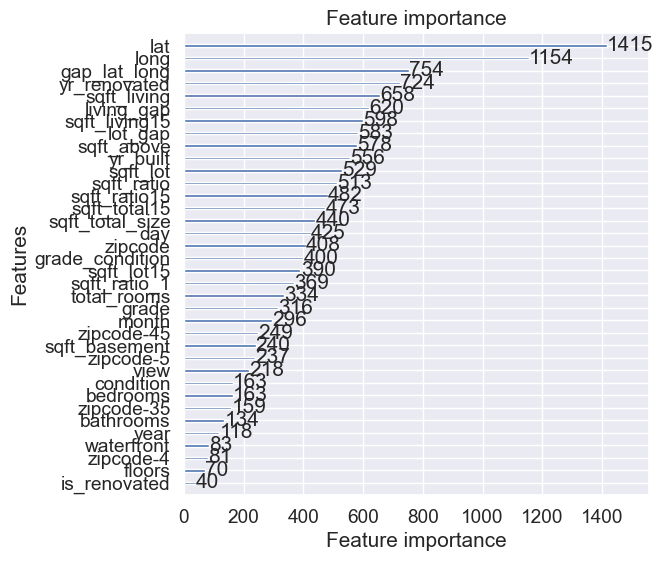

In [194]:
f, ax = plt.subplots(figsize=(6, 6))
plot_importance(lightgbm3, max_num_features=40, ax=ax)

In [168]:
t_data4 = t_data.copy(True)

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 
                'sqft_above', 'sqft_basement','sqft_living15',
                'sqft_lot15']

t_data4 = log_scaling(t_data4, skew_columns)
t_data4 = lat_long(t_data4)
t_data4 = sep_zipcode(t_data4)
t_data4 = set_yr_renovated(t_data4)
t_data4 = set_total_rooms(t_data4)
t_data4 = set_sqft_gap(t_data4)

t_data4_columns = t_data4.columns
t_data4_columns = t_data4_columns.drop('id')

In [170]:
# categorical label encoding
cat_cols = t_data4.select_dtypes('object').columns.drop('date')
for col in cat_cols:
    le = LabelEncoder()
    t_data4[col] = le.fit_transform(t_data4[col])

In [171]:
X = t_data4.iloc[:train_len, :][t_data4_columns]
sub = t_data4.iloc[train_len:, :][t_data4_columns]

In [178]:
X['date'] = X.date.astype('int')

In [172]:
random_state=2020

gboost4 = GradientBoostingRegressor(random_state=random_state)
xgboost4 = XGBRegressor(random_state=random_state)
lightgbm4 = LGBMRegressor(random_state=random_state)
rdforest4 = RandomForestRegressor(random_state=random_state)

models4 = [{'model':gboost4, 'name':'GradientBoosting'}, {'model':xgboost4, 'name':'XGBoost'},
          {'model':lightgbm4, 'name':'LightGBM'}, {'model':rdforest4, 'name':'RandomForest'}]

In [173]:
gboost4_grid = {
    "n_estimators": range(50, 100, 25),
    "max_depth": [1, 2, 4],
    "learning_rate": [0.0001, 0.001, 0.01, 0.1],
    "subsample": [0.7, 0.9],
    "max_features": list(range(1, len(t_data5_columns), 2)),
}

res, gboost4 = my_GridSearch(models4[0], X, log_y, gboost4_grid)
res

Fitting 5 folds for each of 624 candidates, totalling 3120 fits


,learning_rate,max_depth,max_features,n_estimators,subsample,score,RMSLE
607,0.1000,4,17,75,0.9,-0.031000,0.176069
615,0.1000,4,21,75,0.9,-0.031028,0.176149
614,0.1000,4,21,75,0.7,-0.031042,0.176188
619,0.1000,4,23,75,0.9,-0.031188,0.176600
622,0.1000,4,25,75,0.7,-0.031243,0.176758
...,...,...,...,...,...,...,...
53,0.0001,2,1,50,0.9,-0.278103,0.527355
3,0.0001,1,1,75,0.9,-0.278152,0.527401
2,0.0001,1,1,75,0.7,-0.278152,0.527402
1,0.0001,1,1,50,0.9,-0.278308,0.527549


In [179]:
xgboost4_grid = {
    "colsample_bytree":[1.0],
    "min_child_weight":[1.0,1.2],
    'max_depth': [5,7,8,10], 
    'n_estimators': [1000,1500,2000]
}

res, xgboost4 = my_GridSearch(models4[1], X, log_y, xgboost4_grid)
res[:5]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,colsample_bytree,max_depth,min_child_weight,n_estimators,score,RMSLE
3,1.0,5,1.2,1000,-0.029571,0.171963
4,1.0,5,1.2,1500,-0.029623,0.172113
5,1.0,5,1.2,2000,-0.029646,0.172181
6,1.0,7,1.0,1000,-0.029781,0.172570
7,1.0,7,1.0,1500,-0.029781,0.172570


In [180]:
lgboost4_grid = {
    "learning_rate": [0.05, 0.75, 0.1],
    "num_iterations": [500, 1000, 1500, 2000],
    'max_depth': [5,7,8,10]
}

res, lightgbm4 = my_GridSearch(models4[2], X, log_y, lgboost4_grid)
res[:5]

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,learning_rate,max_depth,num_iterations,score,RMSLE
8,0.05,8,500,-0.025855,0.160794
9,0.05,8,1000,-0.025949,0.161087
4,0.05,7,500,-0.026026,0.161327
12,0.05,10,500,-0.026047,0.161391
5,0.05,7,1000,-0.026082,0.161499


In [ ]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# res, rdforest4 = my_GridSearch(models4[3], X, log_y, rdforest4_grid)
res, rdforest4 = my_randomSearch(models3_2[3], X, log_y, random_grid)
res

In [ ]:
get_scores(models4, X, log_y, exp_true = True)

#### get worse...

In [190]:
get_cv_score(models4)

Model GradientBoosting CV score : 0.8687
Model XGBoost CV score : 0.8817
Model LightGBM CV score : 0.8835
Model RandomForest CV score : 0.8658


In [197]:
y_pred = AveragingBlending(models4[1:3], X, log_y, sub)

In [198]:
y_pred = np.expm1(y_pred)
sub_out = pd.DataFrame(data={'id':sub.index,'price':y_pred})
sub_out.to_csv('submission4_2.csv', index=False)

![nn](./assets/submission4_2.png)

#### 4.6 t_data6 submission

가능성있는 데이터3 피처대상 하이퍼파라미터 수정

In [214]:
t_data3_2 = t_data3.copy(True)

In [218]:
t_data3_2['date'] = t_data['date']

In [219]:
t_data3_columns = list(t_data3.columns)
t_data3_columns.remove('id')
t_data3_columns.remove('date')

In [220]:
# categorical label encoding
cat_cols = t_data3_2.select_dtypes('object').columns.drop('date')
for col in cat_cols:
    le = LabelEncoder()
    t_data3_2[col] = le.fit_transform(t_data3_2[col])

In [223]:
t_data3_2['date'] = t_data3_2['date'].astype('int')

In [224]:
X = t_data3_2.iloc[:train_len, :][t_data3_columns]
sub = t_data3_2.iloc[train_len:, :][t_data3_columns]

In [225]:
random_state=2020

gboost3_2 = GradientBoostingRegressor(random_state=random_state)
xgboost3_2 = XGBRegressor(random_state=random_state)
lightgbm3_2 = LGBMRegressor(random_state=random_state)
rdforest3_2 = RandomForestRegressor(random_state=random_state)

In [226]:
models3_2 = [{'model':gboost3_2, 'name':'GradientBoosting'}, {'model':xgboost3_2, 'name':'XGBoost'},
          {'model':lightgbm3_2, 'name':'LightGBM'}, {'model':rdforest3_2, 'name':'RandomForest'}]

In [230]:
gboost3_2_grid = {
    'max_depth': [3,5,6,7,8,9,10], 
    'n_estimators': [1000,1500,2000],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
}


#res, gboost3_2 = my_GridSearch(models3_2[0], X, log_y, gboost3_2_grid)
res, gboost3_2 = my_randomSearch(models3_2[0], X, log_y, gboost3_2_grid)

res

Fitting 3 folds for each of 100 candidates, totalling 300 fits


,subsample,n_estimators,min_samples_split,min_samples_leaf,max_depth,learning_rate,score,RMSLE
80,0.950,2000,0.500000,0.100000,7,0.20,-0.032372,0.179922
79,1.000,1500,0.318182,0.136364,10,0.15,-0.032886,0.181345
46,0.850,2000,0.281818,0.136364,10,0.15,-0.033252,0.182351
78,0.900,2000,0.427273,0.172727,6,0.20,-0.035118,0.187397
50,0.900,2000,0.390909,0.172727,3,0.15,-0.035336,0.187980
...,...,...,...,...,...,...,...,...
58,0.900,1500,0.100000,0.463636,8,0.10,-0.278667,0.527889
10,0.800,1500,0.209091,0.427273,10,0.15,-0.278670,0.527892
73,0.618,1500,0.245455,0.500000,6,0.15,-0.278677,0.527898
49,0.618,1500,0.318182,0.318182,5,0.15,-0.278677,0.527898


In [231]:
xgboost3_2_grid = {
    "colsample_bytree":[0.5,1.0],
    "min_child_weight":[1.0,1.2],
    'max_depth': [5,7,8,10], 
    'n_estimators': [500,1000,1500,2000],
    "subsample" : [0.5, 0.7, 0.9],
    'eta' : [0.1]
}

#res, xgboost3_2 = my_GridSearch(models3_2[1], X, log_y, xgboost3_2_grid)
res, xgboost3_2 = my_randomSearch(models3_2[1], X, log_y, xgboost3_2_grid)
res

Fitting 3 folds for each of 100 candidates, totalling 300 fits


,subsample,n_estimators,min_child_weight,max_depth,eta,colsample_bytree,score,RMSLE
68,0.9,500,1.0,5,0.1,0.5,-0.026560,0.162972
40,0.7,500,1.2,5,0.1,1.0,-0.026636,0.163205
64,0.9,500,1.0,7,0.1,0.5,-0.026710,0.163431
35,0.9,1000,1.0,5,0.1,0.5,-0.026808,0.163731
50,0.9,1000,1.0,7,0.1,0.5,-0.026813,0.163746
...,...,...,...,...,...,...,...,...
88,0.5,1500,1.2,7,0.1,1.0,-0.028789,0.169673
29,0.5,2000,1.2,7,0.1,1.0,-0.028801,0.169707
5,0.5,2000,1.0,10,0.1,1.0,-0.028820,0.169764
20,0.5,1000,1.0,10,0.1,1.0,-0.028820,0.169765


In [232]:
lgboost3_2_grid = {
    "learning_rate": [0.05, 0.75, 0.1],
    "num_iterations": [500, 1000, 1500, 2000],
    'max_depth': [5,7,8,10],
    'min_data_in_leaf': [10, 15, 20, 30]
    
}

# res, lightgbm3_2 = my_GridSearch(models3_2[2], X, log_y, lgboost3_2_grid)
res, lightgbm3_2 = my_randomSearch(models3_2[2], X, log_y, lgboost3_2_grid)
res

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


,num_iterations,min_data_in_leaf,max_depth,learning_rate,score,RMSLE
86,500,10,8,0.05,-0.026331,0.162269
52,500,20,10,0.05,-0.026350,0.162325
28,500,30,10,0.05,-0.026363,0.162367
26,500,20,7,0.05,-0.026478,0.162721
8,500,10,7,0.05,-0.026507,0.162809
...,...,...,...,...,...,...
80,2000,15,10,0.75,-0.046672,0.216038
93,500,10,8,0.75,-0.046946,0.216670
63,1000,10,8,0.75,-0.046960,0.216702
23,1500,10,8,0.75,-0.046960,0.216702


In [233]:
rdforest3_2_grid = {
    'n_estimators': [200, 500, 1000, 1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,4,5,6,7,8,10,15,20]
}

# res, rdforest3_2 = my_GridSearch(models3_2[3], X, log_y, rdforest3_2_grid)
res, rdforest3_2 = my_randomSearch(models3_2[3], X, log_y, rdforest3_2_grid)

res

Fitting 3 folds for each of 100 candidates, totalling 300 fits


,n_estimators,max_features,max_depth,score,RMSLE
68,1500,auto,20,-0.032116,0.179211
97,1000,auto,20,-0.032119,0.179218
73,500,auto,20,-0.032192,0.179420
90,200,auto,20,-0.032259,0.179608
99,1000,auto,15,-0.032317,0.179768
...,...,...,...,...,...
47,1500,sqrt,3,-0.091174,0.301950
9,1500,log2,3,-0.095669,0.309304
1,1000,log2,3,-0.096320,0.310354
32,500,log2,3,-0.096555,0.310733


In [234]:
get_scores(models3_2, X, log_y, exp_true = True)

,RMSE
RandomForestRegressor,127396.175580
GradientBoostingRegressor,123237.841644
LGBMRegressor,109622.020296
XGBRegressor,108329.824182


lgbm, xgb

In [235]:
get_cv_score(models3)

Model GradientBoosting CV score : 0.8961
Model XGBoost CV score : 0.8864
Model LightGBM CV score : 0.8895
Model RandomForest CV score : 0.8582


### submission5 - all model blending

In [236]:
y_pred = AveragingBlending(models3_2, X, log_y, sub)

In [237]:
y_pred = np.expm1(y_pred)
sub_out = pd.DataFrame(data={'id':sub.index,'price':y_pred})
sub_out.to_csv('submission5.csv', index=False)

### submission6 - xgboost, lightgbm blending

In [238]:
y_pred = AveragingBlending(models3_2[1:3], X, log_y, sub)

In [239]:
y_pred = np.expm1(y_pred)
sub_out = pd.DataFrame(data={'id':sub.index,'price':y_pred})
sub_out.to_csv('submission6.csv', index=False)

![nn](./assets/submission6.png)

### submission7 - only xgboost

In [242]:
y_pred = AveragingBlending([models3_2[1]], X, log_y, sub)

In [243]:
y_pred = np.expm1(y_pred)
sub_out = pd.DataFrame(data={'id':sub.index,'price':y_pred})
sub_out.to_csv('submission7.csv', index=False)

![nn](./assets/submission7.png)

### submission8 - only lgboost

In [245]:
y_pred = AveragingBlending([models3_2[2]], X, log_y, sub)

In [246]:
y_pred = np.expm1(y_pred)
sub_out = pd.DataFrame(data={'id':sub.index,'price':y_pred})
sub_out.to_csv('submission8.csv', index=False)

![nn](./assets/submission8.png)

## 회고

- 최종적으로 private 111402.41911 점을 기록했다...
![nn](./assets/submission4.png)

#### 피처 엔지니어링
- 모델 변수중요도 확인 결과 lat, long, is_renovated 순으로 영향력이 큰 것을 확인할 수 있었다
- 추가적인 지역명 등의 공간데이터를 활용할 경우 설명력을 높일 수 있을 것으로 예상된다

#### 하이퍼 파라미터 튜닝
- 하이퍼 파라미터 튜닝 시간 문제로 gridsearch에서 randomsearch로 변경했고 상대적으로 빨라졌지만 추가적인 하이퍼 파라미터 조절이 필요할 것 같다

#### 모델링
- 모델 중에서는 lightgb, xgb가 randomforest, gb에 비교해 성능이 높게 도출되었으며 상위 성적에도 둘을 average한 결과가 사용되었다